# Feature Importance Implementation And Understanding

Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model while a low score probably means the the feature does not have significant impact on the target variable so we can drop it. Therefore, you can see there are several benifits feature importance gives us:<br>
1) Understand the data better<br>
2) Help us improve the model<br>
3) Make it easier to interpret the model<br>

In this article, I will talk about several popular methods to calculate feature importance and explain their advantages and disadvantages. For Spearman rank correlation, drop column importance, permutation importance, I implement functions to calculate them. For PCA, shap importance, I import the packeges directly.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from typing import Mapping
from matplotlib import pyplot as plt
#import pymrmr
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.base import clone
import shap
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from featimp import *
import seaborn

#### Load the cancer data

In [2]:
cancer = load_breast_cancer()
x_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_df = pd.DataFrame(cancer.target, columns=["target"])
cancer_df = pd.concat([x_df, y_df], ignore_index=True, sort=False, axis=1)
cancer_df.columns = list(cancer.feature_names)+['y']

In [3]:
# train validation split
train_df, val_df = train_test_split(cancer_df, test_size=0.2, random_state=1, stratify=cancer_df.y)
train_df.shape, val_df.shape

((455, 31), (114, 31))

In [4]:
# scale the data 
scaler = StandardScaler()
cols = [col for col in train_df.columns if col != 'y']
train_x_scaled = scaler.fit_transform(train_df.loc[:, cols])
val_x_scaled = scaler.transform(val_df.loc[:, cols])
train_y = train_df.iloc[:, -1]
valid_y = val_df.iloc[:, -1]

# convert scaled data into dataframe
train_x_scaled = pd.DataFrame(train_x_scaled, columns = cols)
val_x_scaled = pd.DataFrame(val_x_scaled, columns = cols)

### 1. Spearman Rank Correlation

<h3><center>
$ r_s =
 \rho_{\operatorname{rg}_X,\operatorname{rg}_Y} =
 \frac{\operatorname{cov}(\operatorname{rg}_X, \operatorname{rg}_Y)}
      {\sigma_{\operatorname{rg}_X} \sigma_{\operatorname{rg}_Y}}
$</center></h3>

The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient, measures the strength and direction of association between two ranked variables. Firstly, let's see the value of spearman rank correlation of the features with target variable in the cancer data set.
(If you are interested in my implementation of spearman rank correlation function, you can check the python file. For the readability and brevity of this article, I have not shown the code here.)

In [5]:
# define the spear_corr function
def spear_corr(df, y):
    spearman_corr = dict()
    X_cols = [col for col in df.columns if col != y]
    target_rank = df[y].rank(axis=0)
    for col in X_cols:
        col_rank = df[col].rank(axis=0)
        cov = col_rank.cov(target_rank)
        std_target, std_col = target_rank.std(), col_rank.std()
        spearman_corr[col] = abs(cov / (std_target * std_col))
    spearman_corr = {k: v for k, v in sorted(spearman_corr.items(), key=lambda item: abs(item[1]),reverse=True)}
    return spearman_corr

In [6]:
corr_spearman = spear_corr(df=cancer_df, y='y')

In [7]:
def plot_feature_imp(importances, title):
    # draw a horizontal bar plot
    fig, ax = plt.subplots(figsize=(15,10))
    ax.barh(np.array([val for val in importances.keys()]), 
            np.array([val for val in importances.values()]), color='#30c9b5') # Horizontal Bar Plot
    
    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    
    # Remove axes splines
    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False) 
    
    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-', linewidth=0.5, alpha=0.2) 
    
    # Set the biggest value on the top 
    ax.invert_yaxis()
    
    # Add Plot Title
    ax.set_title(title, loc='left', pad=-5, fontweight='bold', fontsize=15, color = 'grey')
    return plt

<module 'matplotlib.pyplot' from '/Users/weihe/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

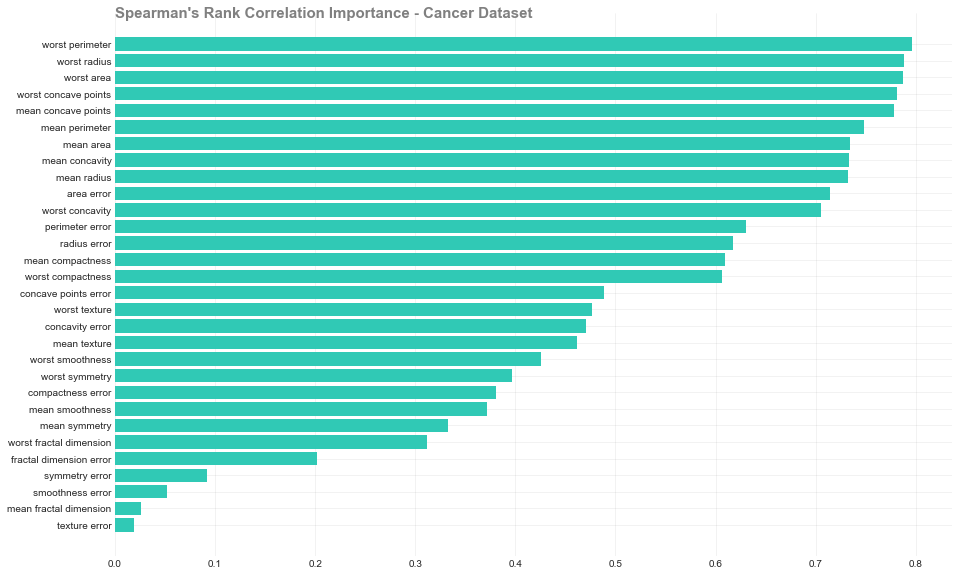

In [8]:
plot_feature_imp(corr_spearman, "Spearman's Rank Correlation Importance - Cancer Dataset")

##### Advantages

1. Spearman's correlation uses rank to calculate the correlations, so it is more robust to outliers.<br>
2. Doesn't assume normal distribution.

##### Disadvantages

1. It is only an approximately calculate measure as actual values are not used for calculations.
2. This method works well for independent features, but suffers in the presence of codependent features.
3. Groups of features with similar relationships to the response variable receive the same or similar ranks, even though just one should be considered important
4. Seems inappropriate for categorical variables

### 2. PCA: Importance directly from the data

• PCA transforms data into a new space characterized by eigenvectors of X and identifies features that explain the most variance in the new space.<br>
• If the first principal component covers a large percentage of the variance, the “loads” associated with that component can indicate importance of features in the original X space.<br>
• Seems inappropriate for categorical variables.<br>

In [9]:
# fit PCA
pca = PCA(n_components=3, random_state=2)
pca.fit(train_x_scaled)
pca.explained_variance_ratio_

array([0.44266711, 0.19099952, 0.09321825])

1. We can see that in the PCA space, the variance is maximized along PC1 (explains 44% of the variance) and PC2 (explains 19% of the variance). Together, they explain 63%.<br>
2. The importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude — higher importance). <br>
   Let's check the absolute value of coefficients of the first two principal components.

In [10]:
print(abs( pca.components_[0] ))

[0.21986218 0.09989726 0.22808256 0.22149485 0.14502268 0.24120735
 0.25892246 0.26043829 0.14009333 0.06743408 0.19968221 0.01812104
 0.20544291 0.19548482 0.00684854 0.17517869 0.1527039  0.18477362
 0.04959859 0.10136863 0.2291757  0.10389377 0.23735789 0.2254471
 0.12824493 0.21123168 0.23029663 0.250854   0.1253408  0.13255734]


In [11]:
print(abs( pca.components_[1] ))

[0.2310746  0.05071229 0.2129784  0.23039614 0.18337461 0.14435488
 0.05584229 0.03978584 0.18389256 0.36135646 0.12847298 0.07999067
 0.11448434 0.1691339  0.19313304 0.22780617 0.19140345 0.11743233
 0.16889967 0.28340149 0.21469468 0.02893438 0.19571046 0.2159673
 0.18965328 0.15322449 0.10909136 0.00154158 0.15454482 0.28607499]


In [12]:
# Save importances into a dict and sort it reversely by value
pca_importances_1 = abs(pca.components_[0])
pca_featimp_1 = {cols[i]:pca_importances_1[i] for i in range(len(cols))}
pca_featimp_1 = dict(sorted(pca_featimp_1.items(), key=lambda x: x[1], reverse=True))

pca_importances_2 = abs(pca.components_[1])
pca_featimp_2 = {cols[i]:pca_importances_2[i] for i in range(len(cols))}
pca_featimp_2 = dict(sorted(pca_featimp_2.items(), key=lambda x: x[1], reverse=True))

In [13]:
def pca_feature_imp(importances1, importances2, title1, title2):
    # draw a horizontal bar plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,12))
    ax[0].barh(np.array([val for val in importances1.keys()]), 
               np.array([val for val in importances1.values()]), color='#30c9b5')
    ax[1].barh(np.array([val for val in importances2.keys()]), 
               np.array([val for val in importances2.values()]), color='#30c9b5')
    
    # Remove x,y Ticks
    ax[0].xaxis.set_ticks_position('none') 
    ax[0].yaxis.set_ticks_position('none')
    ax[1].xaxis.set_ticks_position('none') 
    ax[1].yaxis.set_ticks_position('none')
    
    # Remove axes splines
    for s in ['top','bottom','left','right']:
        ax[0].spines[s].set_visible(False)
        ax[1].spines[s].set_visible(False)
    
    # Add x,y gridlines
    ax[0].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2) 
    ax[1].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2) 
    # Set the biggest value on the top 
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    # Add Plot Title
    ax[0].set_title(title1, loc='left', pad=-5, fontweight='bold', fontsize=15, color = 'grey')
    ax[1].set_title(title2, loc='left', pad=-5, fontweight='bold', fontsize=15, color = 'grey')
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/Users/weihe/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

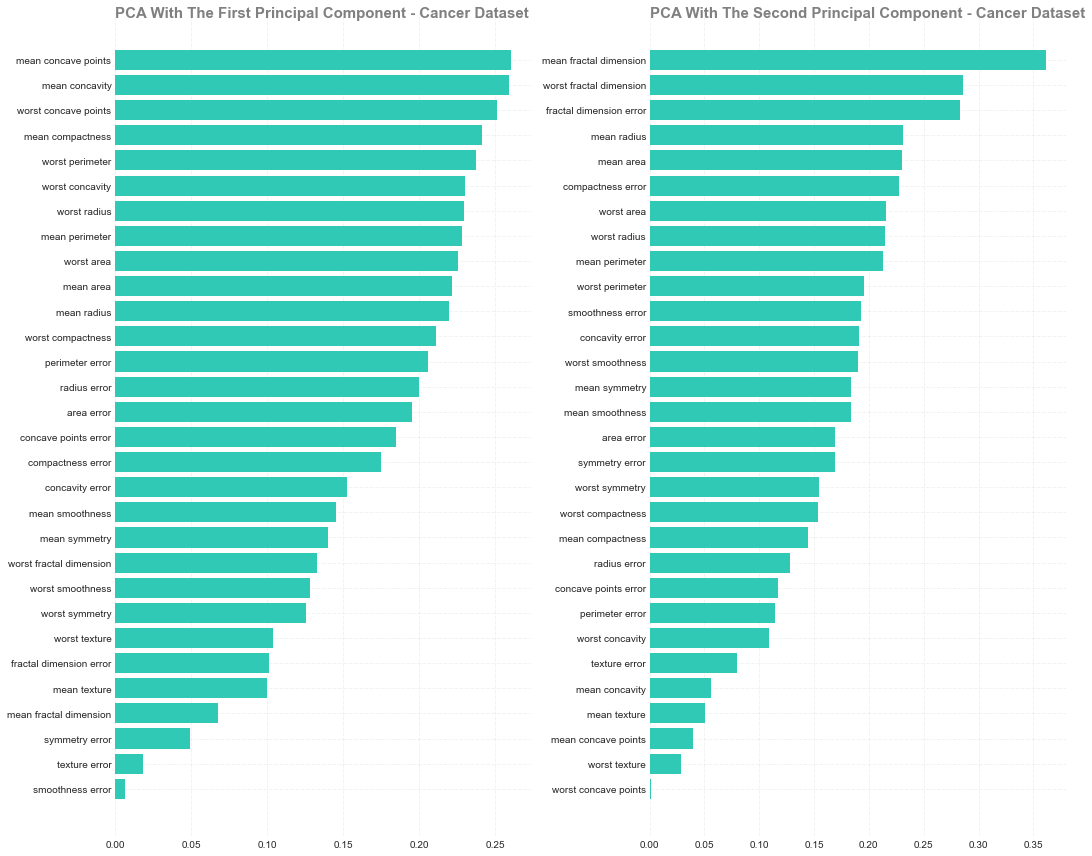

In [14]:
title1 = "PCA With The First Principal Component - Cancer Dataset"
title2 = "PCA With The Second Principal Component - Cancer Dataset"
pca_feature_imp(pca_featimp_1, pca_featimp_2, title1, title2)

#### Advantages

1. Removes Correlated Features: <br>In a real-world scenario, this is very common that we get thousands of features in your dataset. We need to find out the correlation among the features (correlated variables) so as to reduce the number of features.
2. Spead up the training process:<br>PCA is a very common way to speed up Machine Learning algorithm by getting rid of correlated variables which don’t contribute in any decision making.

#### Disadvantages

1. After implementing PCA on the dataset, the original features will turn into Principal Components. Principal Components are the linear combination of your original features. Principal Components are not as readable and interpretable as original features.
2. Sometimes the first principal component cannot covers a large percentage of the variance, then we cannot simplely consider the "loads" associated with the first principle component as importance of features in the original X space. In this case, we may need to select the important features from two or three principle components which may be complicated.

### 3. Drop Column Importance

The idea of Drop column importance is quite simple. It is a brute force mechanism to examine importance of any feature or combination of features.<br>
• Procedure:
1. Compute validation metric for model trained on all features
2. Drop column from training set
3. Retrain model
4. Compute validation metric set
5. Importance score is the change in metric <br>

It answers the question of how loss of a feature affects overall model performance (which might not be actual importance)

In [15]:
# define the drop column importance function
def dropcol_importances(model,X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    baseline = model.oob_score_
    imp = {}
    for col in X_train.columns:
        X_train_ = X_train.drop(col, axis=1)
        X_valid_ = X_valid.drop(col, axis=1)
        model_ = clone(model)
        model_.random_state = 2
        model_.fit(X_train_, y_train)
        m = model_.oob_score_
        imp[col] = baseline - m
    drop_imp = {k: v for k, v in sorted(imp.items(), key=lambda item: item[1],reverse=True)}
    return drop_imp

In [16]:
## train rf model with oob score for drop column feature importance
rf_ = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=2)
rf_.fit(train_x_scaled, train_y)
val_preds = rf_.predict(val_x_scaled)
train_preds = rf_.predict(train_x_scaled)
acc_train = accuracy_score(train_y, train_preds)
acc_val = accuracy_score(valid_y, val_preds)
print(f'train accuracy: {acc_train:.3f} validation accuracy: {acc_val:.3f}')

train accuracy: 1.000 validation accuracy: 0.947


In [17]:
dropcol_imp = dropcol_importances(rf_,train_x_scaled, train_y, val_x_scaled, valid_y)

<module 'matplotlib.pyplot' from '/Users/weihe/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

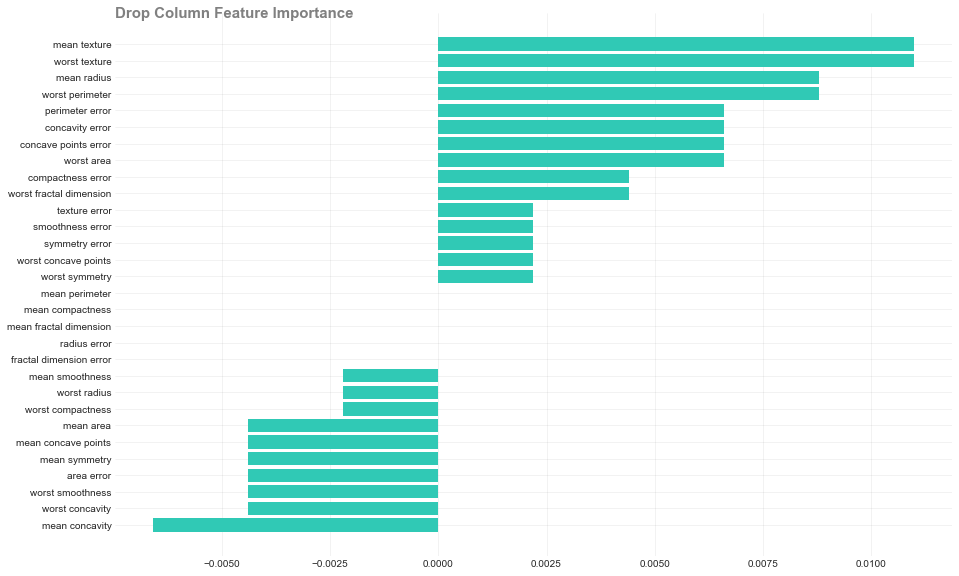

In [18]:
plot_feature_imp(dropcol_imp, "Drop Column Feature Importance")

#### Advantages

1. Easy to understand
2. Simple to implement
3. Very direct means of measuring importance
4. Works for any machine learning model

#### Disadvantages

1. It is very expensive because it means retraining the model n times for n features.
2. Codependent features often result in 0 or very low importance because after dropping there is still codependent features in the model.

### 4. Permutation Importances

Similar to drop column, but permute the feature instead of dropping it from the model. Keeps same distribution but breaks relationships.<br>
• Procedure:
1. Compute validation metric for model trained on all features
2. Permute column Xj in validation set
3. Compute validation metric set
4. Importance score is the change in metric

In [19]:
## train rf model with oob score for drop column feature importance
rf_ = RandomForestClassifier(n_estimators=30, oob_score=True, random_state=2)
rf_.fit(train_x_scaled, train_y)
val_preds = rf_.predict(val_x_scaled)
train_preds = rf_.predict(train_x_scaled)
acc_train = accuracy_score(train_y, train_preds)
acc_val = accuracy_score(valid_y, val_preds)
print(f'train accuracy: {acc_train:.3f} validation accuracy: {acc_val:.3f}')

train accuracy: 1.000 validation accuracy: 0.956


In [20]:
def permutation_importances(model, X_valid, y_valid, metric=accuracy_score):
    baseline = metric(y_valid, model.predict(X_valid))
    imp = {}
    for col in X_valid.columns:
        save = X_valid[col].copy()
        X_valid[col] = np.random.permutation(X_valid[col])
        m = metric(y_valid, model.predict(X_valid))
        X_valid[col] = save
        imp[col] = baseline - m
    perm_imp = {k: v for k, v in sorted(imp.items(), key=lambda item: item[1],reverse=True)}
    return perm_imp

In [21]:
perm_imp = permutation_importances(rf_, val_x_scaled, valid_y)

<module 'matplotlib.pyplot' from '/Users/weihe/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

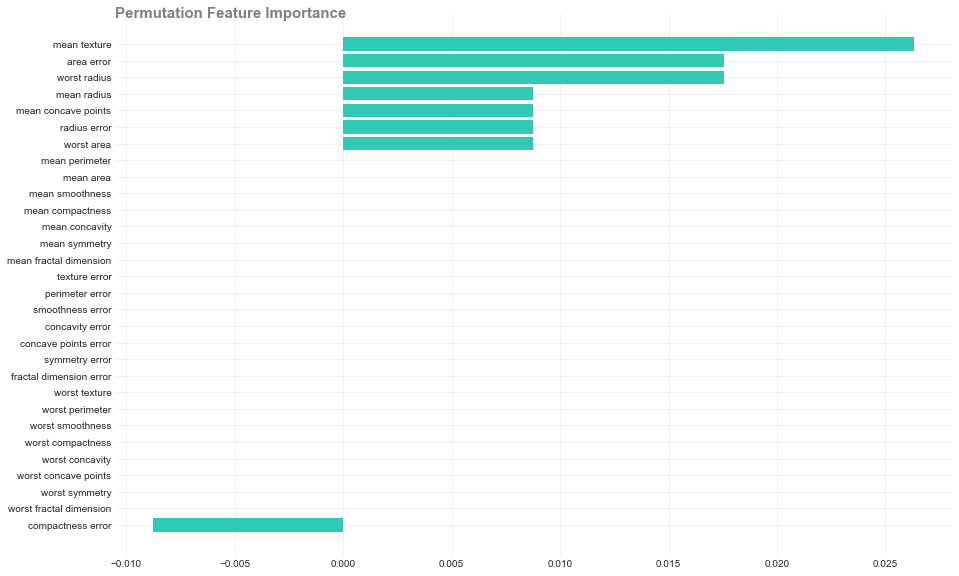

In [22]:
plot_feature_imp(perm_imp, "Permutation Feature Importance")

#### Advantages

1. Easy to understand and simple to implement
2. Works for any machine learning model
3. No need to retrain the model so much more efficient than drop column importance

#### Disadvantages

1. Can create nonsensical records through permutation, such as pregnant male, which makes the results suspect.
2. It gives near zero importance to highly correlated / identical columns.

### 5. Shap Importance

SHAP (Shapley Additive Explanations) is a method to explain individual predictions, based on the game theoretically optimal Shapley values.<br>
SHAP can give importance scores to every single record and visualize it well, which is very insightful.

In [23]:
# Explain the model’s predictions using shap. Collect the explainer and the shap values.
shap_ = shap.TreeExplainer(rf_, data=train_x_scaled)
shap_values = shap_.shap_values(X=val_x_scaled, y=valid_y)                                                             

#### Plotting our Results
##### 1. Force plot
Force plot gives us the explainability of a single model prediction. In this plot, we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or a deep understanding of a particular case.

In [24]:
# load JS visualization code to notebook
shap.initjs()

In [25]:
# Draw the force plot with record number 10 and class 1
shap.force_plot(shap_.expected_value[1], shap_values[1][10], feature_names=train_x_scaled.columns)

From the plot we can see:
1. The model predict_proba value: 0.27 (For the 11th row of record in the validation set to be class 1).
2. The base value: this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.572
3. Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.
4. The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.
5. Mean area, mean concave points and other blue features decrease the property that the class is class 1, worst radius increases the property value.

In [26]:
# Draw the force plot with record number 10 and class 0
shap.force_plot(shap_.expected_value[0], shap_values[0][10], feature_names=train_x_scaled.columns)

We can see the result for class 0 is exactly the opposite to the result for class 1.<br>

##### 2. Summary plot
1. We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).<br>
2. In this plot, the impact of a feature on the classes is stacked to create the feature importance plot. Thus, if you created features in order to differentiate a particular class from the rest, that is the plot where you can see it.<br>
3. In our example of cancer data, we only have two classes and they are complementary, so you can see the model uses the same features equally.

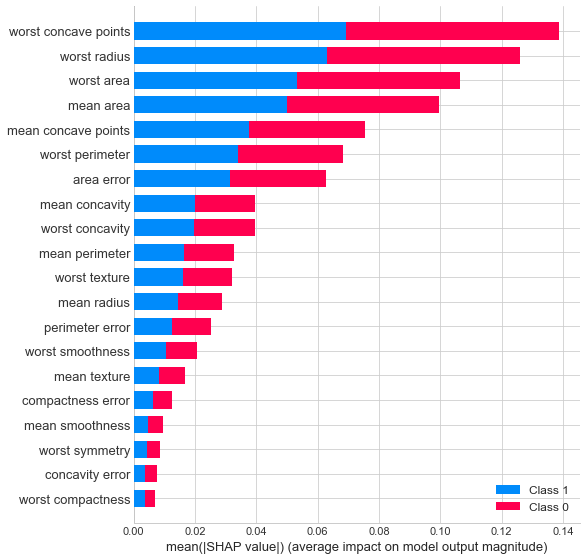

In [27]:
shap.summary_plot(shap_values, features=val_x_scaled, feature_names=val_x_scaled.columns)

### 6. Comparison of different techniques

Now, we have calculated the feature importances for the random forest model in 5 ways. Here is a idea that we can compare the different performances of the feature importance methods. That is we can fit the model with p features selected by different feature importance method, then compare the value of metrics of this 5 models. The. model with better performance also means the corresponding feature importance method perform better.

In [363]:
def compare_13(model, train, val, train_y, val_y, feat_imp, metric=log_loss):
    losses = []
    for i in range(1, 14):
        model_ = clone(model)
        model_.random_state = 2
        features = [col for col in feat_imp.keys()][:i]
        model_.fit(train.loc[:, features], train_y)
        valid_prob = model_.predict_proba(val.loc[:, features])
        log_loss_val = metric(val_y, valid_prob)
        losses.append(log_loss_val)
    return losses

In [364]:
## taking mean of absolute shap values for each record and then summing them up across two target classes
imp = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0)
shap_imp = dict(zip([col for col in train_x_scaled.columns], imp))
shap_imp = dict(sorted(shap_imp.items(), key=lambda x: x[1], reverse=True))

In [365]:
# getting loss after top 1,2,...N features dropped
loss_spearman = compare_13(model=rf_, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=corr_spearman)
loss_pca = compare_13(model=rf_, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=pca_featimp_1)
loss_dropcol = compare_13(model=rf_, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=dropcol_imp)
loss_permcol = compare_13(model=rf_, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=perm_imp)
loss_shap = compare_13(model=rf_, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=shap_imp)

In [376]:
# Plotting results
def plot_compare(loss_spearman, loss_pca, loss_dropcol, loss_permcol, loss_shap):
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()
    plt.plot(range(1, len(loss_spearman)+1), loss_spearman,color='red', marker='o',  label='Spearman')
    plt.plot(range(1, len(loss_pca)+1), loss_pca, color='blue', marker='',  label='PCA')
    plt.plot(range(1, len(loss_dropcol)+1), loss_dropcol, color='green', marker='v',  label='Drop Column')
    plt.plot(range(1, len(loss_permcol)+1), loss_permcol, color='yellow', marker='s',  label='Permutation')
    plt.plot(range(1, len(loss_shap)+1), loss_shap, color='black', marker='+',  label='SHAP') 
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylabel('Log Loss', fontsize=15)
    ax.set_xlabel('Top N selected features', fontsize=15)
    ax.grid(False)
    plt.show()

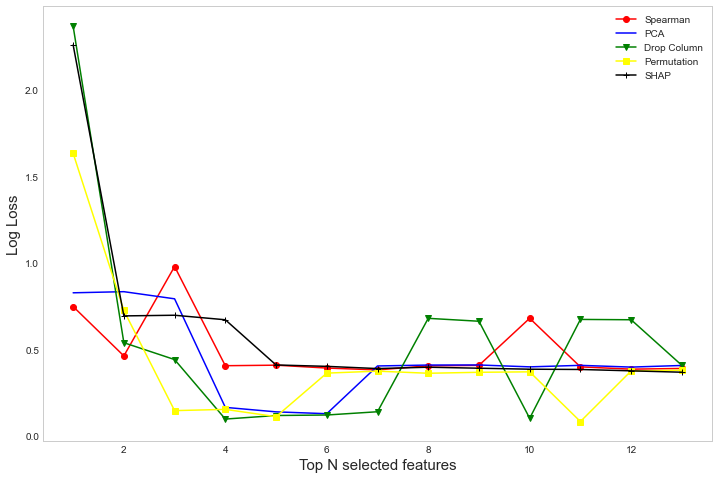

In [377]:
plot_compare(loss_spearman, loss_pca, loss_dropcol, loss_permcol, loss_shap)

From the above loss plots of random forests models we can see, losses of SHAP, drop column, and permutation importances decrease quickly when we add more features at beginning. PCA is most stable.<br>
But it is often the case that features determined for one model do not export well to other models. Let's also test the performances of these feature importances on XGB boosting.

##### Train the XGB model

In [88]:
# use verbosity = 0 and use_label_encoder=False to hide the warnings
model_XGB = XGBClassifier(verbosity = 0,random_state=2,use_label_encoder=False)
model_XGB.fit(train_x_scaled, train_y, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

Because XGB does not have defined OOB score function, we need to define the dropcol_importances function for XGB model individually.

In [381]:
def dropcol_importances_XGB(model,X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    model.random_state = 2
    valid_prob = model.predict_proba(X_valid)
    baseline = log_loss(y_valid, valid_prob)  # Calculate log loss
    imp = {}
    for col in X_train.columns:
        X_train_ = X_train.drop(col, axis=1)
        X_valid_ = X_valid.drop(col, axis=1)
        model_ = clone(model)
        model_.random_state = 2
        model_.fit(X_train_, y_train)
        valid_prob_ = model_.predict_proba(X_valid_)
        m = log_loss(y_valid, valid_prob_)
        imp[col] = baseline - m
    drop_imp = {k: v for k, v in sorted(imp.items(), key=lambda item: item[1],reverse=True)}
    return drop_imp

In [378]:
# get the feature importances for dropcol and permutation
dropcol_imp_XGB = dropcol_importances_XGB(model_XGB,train_x_scaled, train_y, val_x_scaled, valid_y)
perm_imp_XGB = permutation_importances(model_XGB, val_x_scaled, valid_y)

# get the feature importances for SHAP
shap_XGB = shap.TreeExplainer(model_XGB, data=train_x_scaled)
shap_values_XGB = shap_XGB.shap_values(X=val_x_scaled, y=valid_y)   
imp = np.mean(np.abs(shap_values_XGB), axis=1)
shap_imp_XGB = dict(zip([col for col in train_x_scaled.columns], imp))
shap_imp_XGB = dict(sorted(shap_imp_XGB.items(), key=lambda x: x[1], reverse=True))

In [379]:
loss_spearman_ = compare_13(model=model_XGB, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=corr_spearman)
loss_pca_ = compare_13(model=model_XGB, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=pca_featimp_1)
loss_dropcol_ = compare_13(model=model_XGB, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=dropcol_imp_XGB)
loss_permcol_ = compare_13(model=model_XGB, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=perm_imp_XGB)
loss_shap_ = compare_13(model=model_XGB, train=train_x_scaled, val=val_x_scaled, train_y = train_y, val_y = valid_y, feat_imp=shap_imp_XGB)

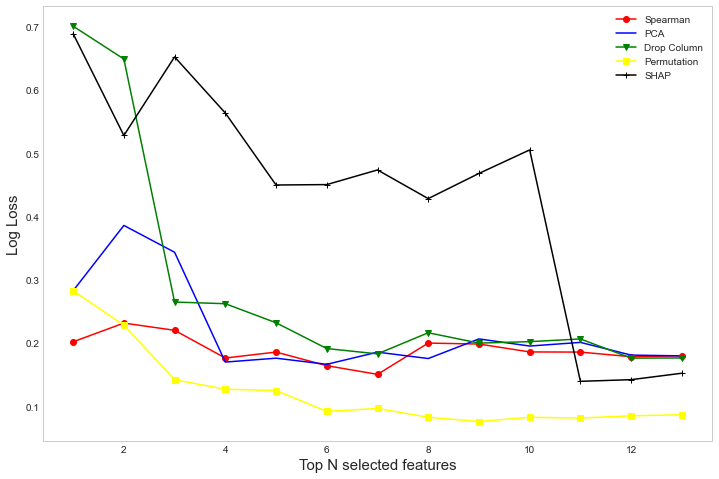

In [380]:
# Plotting results
plot_compare(loss_spearman_, loss_pca_, loss_dropcol_, loss_permcol_, loss_shap_)

From the Loss plot of XGB models we can see, generally permutation importance has the best performance for XGB.

### 7.  Automatic Feature Selection

Once you have an ordering of features from most to least important, we need a mechanism to drop off unimportant features and keep the top k, for some k we don't know beforehand.<br>
Here, we are going to implement an automated mechanism that selects the top k features automatically that gives the best validation error:<br> 
1. We need to get a baseline validation metric appropriate for a classifier or a regressor then get the feature importances. <br>
2. Drop the lowest importance feature and retrain the model and re-computing the validation metric. <br>
3. If the validation metric is worse, then we have dropped one too many features.

In [175]:
def get_best_model(model, train_x, val_x, train_y, valid_y, y, metric=log_loss):
    model_ = clone(model)
    model_.random_state = 2
    model_.fit(train_x, train_y)
    preds = model_.predict_proba(val_x)
    val_loss = metric(valid_y, preds)
    shap_imp = get_shap_imp(model_, train_x, val_x, valid_y)
    feat = [col for col in val_x.columns]
    removed_feat = []

    for i in range(len(val_x.columns)):
        remove_feat = feat[np.argmin(shap_imp)]
        removed_feat.append(remove_feat)
        selected_feat = [col for col in feat if col not in removed_feat]
        print(f'Round {i}: drop feature of: {remove_feat}')
        model_ = clone(model)
        model_.random_state = 2
        X_train_new = train_x.drop(columns=removed_feat)
        X_val_new = val_x.drop(columns=removed_feat)
        model_.fit(X_train_new, train_y)
        preds_new = model_.predict_proba(X_val_new)
        new_val_loss = metric(valid_y, preds_new)
        
        if new_val_loss > val_loss:
            removed_feat = [col for col in removed_feat if col != remove_feat]
            print(f'Loss before dropping: {val_loss:.3f}, loss after dropping: {new_val_loss:.3f}')
            print(f'Stopping iterations, because dropping increasing loss. \n\nFinally, we dropped features:{removed_feat}')
            return model_, removed_feat
        
        print(f'Loss before dropping: {val_loss:.3f}, loss after dropping: {new_val_loss:.3f}')
        shap_imp = get_shap_imp(model_, X_train_new, X_val_new, valid_y)
        print(f'Loss decreased. Let us continue!','\n')
        feat = [col for col in X_train_new.columns]
        val_loss = new_val_loss

def get_shap_imp(model_, train_x, val_x, valid_y):
    shap_values = shap.TreeExplainer(model_, data=train_x).shap_values(X=val_x, y=valid_y, check_additivity=False)
    shap_imp = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0)
    return shap_imp

In [176]:
model, removed_feat = get_best_model(model=rf_, train_x=train_df, val_x=val_df, train_y=train_y, valid_y=valid_y, y='y')

Round 0: drop feature of: texture error
Loss before dropping: 0.042, loss after dropping: 0.039
Loss decreased. Let us continue! 

Round 1: drop feature of: compactness error
Loss before dropping: 0.039, loss after dropping: 0.020
Loss decreased. Let us continue! 

Round 2: drop feature of: mean fractal dimension
Loss before dropping: 0.020, loss after dropping: 0.038
Stopping iterations, because dropping increasing loss. 

Finally, we dropped features:['texture error', 'compactness error']


### 8. Variance For Feature Importance

We can get several results by bootstrapping the X,y data, so as to compute variance or standard deviation of the feature importances. 

In [245]:
def get_std(model, train_x, val_x, valid_y, metric=log_loss):
    shap_imp_ = np.zeros((50,val_x.shape[1]))
    for i in range(50):
        idx = np.random.choice(range(val_x.shape[0]), size=int(val_x.shape[0]*2/3), replace=False)
        val_new = val_x.iloc[idx, :]
        shap_imp_[i] = get_shap_imp(model, train_x, val_new, valid_y)
    return np.std(shap_imp_, axis=0)

Get permutation importances and std

In [351]:
pd.options.mode.chained_assignment = None
shap_imp_ = get_shap_imp(rf_, train_x_scaled, val_x_scaled, valid_y)
shap_var = get_std(rf_, train_x_scaled, val_x_scaled, valid_y)
list_tuples = list(zip(shap_imp_,shap_var))
shap_dict = dict(zip([col for col in train_x_scaled.columns], list_tuples))
shap_dict = dict(sorted(shap_dict.items(), key=lambda x: x[1][0], reverse=True))

In [272]:
def plot_feat_imp_erros(importances, title):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.barh(np.array([val for val in importances.keys()]), 
            np.array([val[0] for val in importances.values()]), 
            xerr=np.array([val[1] for val in importances.values()]), color='#30c9b5')
    
    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    
    # Remove axes splines
    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False) 
    
    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-', linewidth=0.5, alpha=0.2) 
    
    # Set the biggest value on the top 
    ax.invert_yaxis()
    ax.set_title(title, loc='left', pad=-5, fontweight='bold', fontsize=15,color='darkgrey')
    return plt

<module 'matplotlib.pyplot' from '/Users/weihe/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

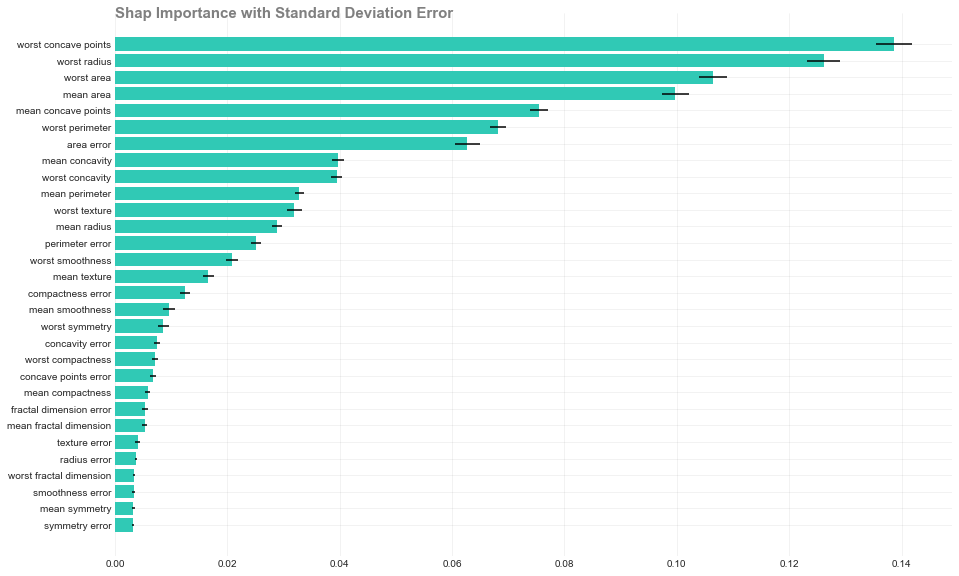

In [369]:
plot_feat_imp_erros(importances=shap_dict, title='Shap Importance with Standard Deviation Error')

We can see generally, higher feature importances have bigger standard deviation error.

### 9.Empirical p-values

Based on statistics theory, we know that P-values associated with a feature's importance distribution will tell us whether the feature's importance is significant.

To do that, we need a null distribution for comparison purposes. The Null distribution came from shuffling the target variable, retraining model and then computing feature importances again.

We then count how many times a feature is as important or more important than the true future importance computed as a baseline. If the proportion comes out to be more than 5%, then that feature importance is not significant.

We can do that in this way:

1. Get baseline feature importance using given validation dataset.

2. Iterate over 80 times : shuffling target variable, retrain model and calculate shap values.

3. P-value of the feature importance is the proportion of times that calculated new feature importances was bigger than baseline feature importance .

In [425]:
def p_values(model, train_x, train_y, val_x, valid_y, target, metric=log_loss):
    shap_imp = np.zeros((100,val_x.shape[1]))
    shap_baseline = get_shap_imp(model, train_x, val_x, valid_y)
    shap_baseline = shap_baseline / np.sum(shap_baseline) 
    for i in range(100):
        Y_train = np.random.permutation(train_y)
        model_ = clone(model)
        model_.random_state = 2
        model_.fit(train_x, Y_train)
        shap_imp[i] = get_shap_imp(model_, train_x, val_x, valid_y) 
        shap_imp[i] = shap_imp[i] / np.sum(shap_imp[i]) 
    diff = shap_imp - shap_baseline 
    p_values = np.sum(diff >= 0, axis=0) / 100 
    return p_values, shap_baseline, shap_imp

In [413]:
p_values, shap_baseline, shap_imp = p_values(rf_, train_x_scaled, train_y, val_x_scaled, valid_y, target='y')

In [420]:
def get_hist(p_values, baseline_score, imp_scores, features, n):
    list_plots = []
    fig,ax = plt.subplots(figsize=(12,8))
    _ = plt.hist(imp_scores[:, n], bins='auto')
    plt.title(f"Histogram of Null Distributions for feature: {features[n]}. Corresponding p-value: {p_values[n]}",size = 18)
    ax.axvline(x=shap_baseline[n], c='red')
    plt.show()

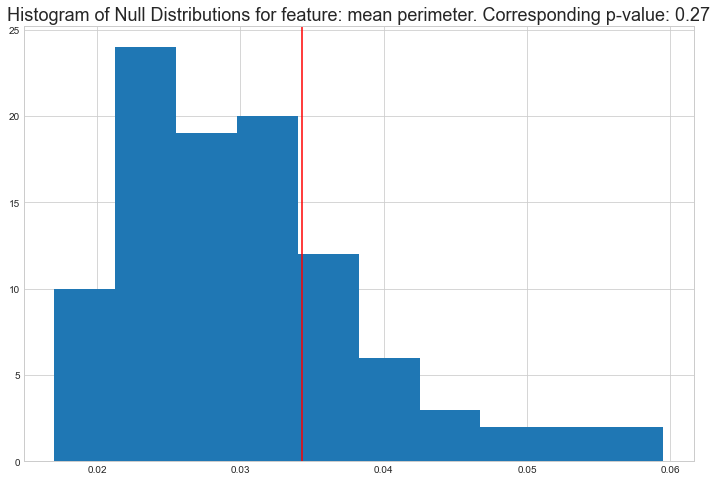

In [421]:
get_hist(p_values=p_values, baseline_score=shap_baseline, imp_scores=shap_imp, features=cols, n=2)

From the above histogram we can see, the proportion of times that the importance after shuffling is bigger than baseline is 0.27. So we can say the feature importance of mean perimeter is not significant.

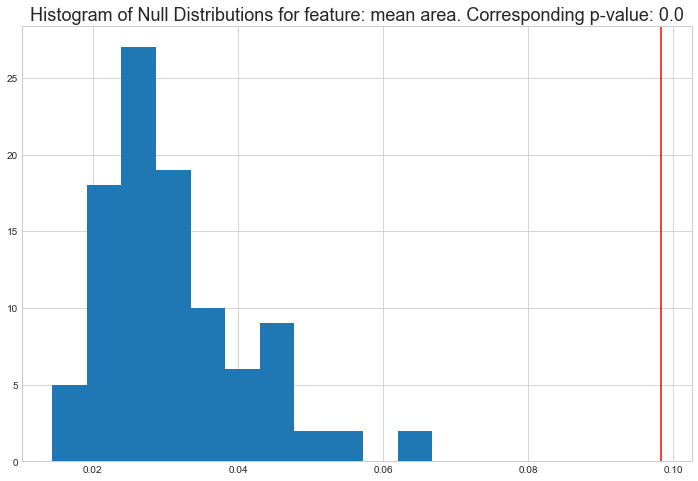

In [422]:
get_hist(p_values=p_values, baseline_score=shap_baseline, imp_scores=shap_imp, features=cols, n=3)

From the above histogram we can see, the proportion of times that the importance after shuffling is bigger than baseline is 0. So we can say the feature importance of mean area is significant.